### House Price Prediction -  Kaggle

Models Used:

1. Random Forest Regression
2. XGBoost Regression


The goal of this project are: 

1. to perform data cleaning and do comprehensive data analysis
2. make features normally distributed by removing Skewness and Kurtosis
2. to creat and test models which are well trained to predict sale prices of the houses



In [2]:
# Importing necessary libraries 

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
import xgboost
import warnings
warnings.filterwarnings('ignore')

In [3]:
from scipy.stats import norm, skew
from scipy import stats
from scipy.special import boxcox1p

In [4]:

#loading the the training dataset
train_df = pd.read_csv('train.csv')

In [5]:
# Taking a view at our training dataset
train_df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [6]:
# Figuring out how many features are categorical and numeric
train_df.get_dtype_counts()

float64     3
int64      35
object     43
dtype: int64

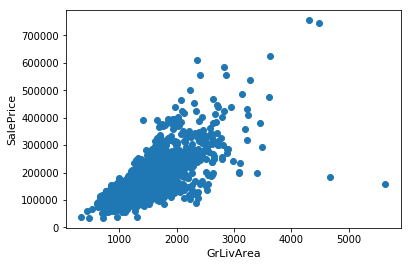

In [7]:
fig, ax = plt.subplots()
ax.scatter(x = train_df['GrLivArea'], y = train_df['SalePrice'])
plt.ylabel('SalePrice', fontsize=11)
plt.xlabel('GrLivArea', fontsize=11)
plt.show()

In [8]:
train_df = train_df.drop(train_df[(train_df['GrLivArea']>4000) & (train_df['SalePrice']<300000)].index)

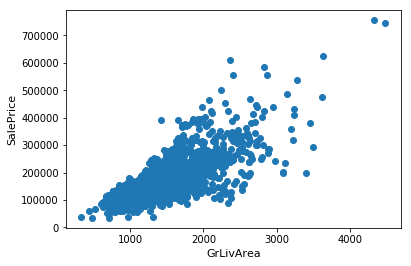

In [9]:
fig, ax = plt.subplots()
ax.scatter(x = train_df['GrLivArea'], y = train_df['SalePrice'])
plt.ylabel('SalePrice', fontsize=11)
plt.xlabel('GrLivArea', fontsize=11)
plt.show()

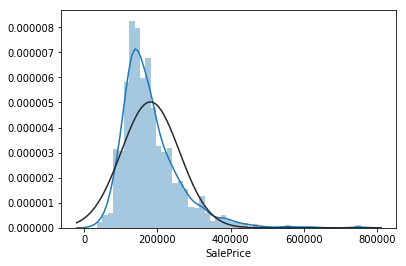

In [10]:
sns.distplot(train_df['SalePrice'], fit=norm)

In [11]:
print("Skewness in SalePrice: %f" % train_df['SalePrice'].skew())
print("Kurtosis in SalePrice: %f" % train_df['SalePrice'].kurt())

Skewness in SalePrice: 1.881296
Kurtosis in SalePrice: 6.523067


In [12]:
train_df["SalePrice"] = np.log1p(train_df["SalePrice"])


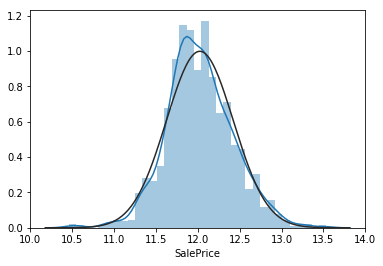

In [13]:
sns.distplot(train_df['SalePrice'], fit=norm)

In [14]:
print("Skewness in SalePrice: %f" % train_df['SalePrice'].skew())
print("Kurtosis in SalePrice: %f" % train_df['SalePrice'].kurt())

Skewness in SalePrice: 0.121580
Kurtosis in SalePrice: 0.804751


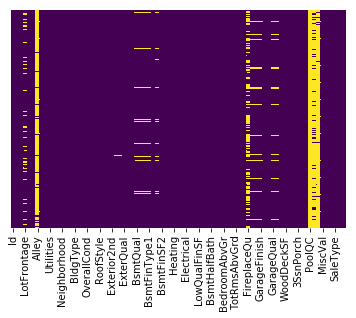

In [15]:
# 1. Data Cleaning
# with the help of heatmap seeing which features have more missing values
sns.heatmap(train_df.isnull(),yticklabels=False,cbar=False,cmap='viridis')

In [16]:
# calculating the percentage of missing values, so we can think if that feature is worth to keep for analysis.
null_count = train_df.isnull().sum().sort_values(ascending = False)
null_percent = (train_df.isnull().sum()/train_df.isnull().count()*100).sort_values(ascending = False)
missing_value = pd.concat([null_count, null_percent ], axis = 1)
missing_value.head(20)

,0,1
PoolQC,1452,99.588477
MiscFeature,1404,96.296296
Alley,1367,93.758573
Fence,1177,80.727023
FireplaceQu,690,47.325103
LotFrontage,259,17.764060
GarageCond,81,5.555556
GarageType,81,5.555556
GarageYrBlt,81,5.555556
GarageFinish,81,5.555556


In [17]:
# droping those features which are having close to or more than 50% of data as missing values
train_df.drop(['Id', 'FireplaceQu', 'MiscFeature', 'Alley', 'Fence','FireplaceQu', 'PoolQC' ], axis = 1, inplace = True)

In [18]:
train_df.isnull().sum().sort_values(ascending = False).sort_values(ascending = False).head(5)

LotFrontage    259
GarageType      81
GarageYrBlt     81
GarageCond      81
GarageQual      81
dtype: int64

In [19]:
# since these features are categorical in nature but prersent in numeric values. Hence conveting then into string type.
train_df['MSSubClass'] = train_df['MSSubClass'].apply(str)
train_df['YrSold'] = train_df['YrSold'].astype(str)
train_df['MoSold'] = train_df['MoSold'].astype(str)

In [20]:
# this function will replace the missing values for categorical feature with the most frequent category of that column, 
# and for numeric features with the mean of that column
def missing_value_impute(df):
    miss_sum = df.isnull().sum()
    miss_list = miss_sum[miss_sum > 0]
    
    for feature in list(miss_list.index):
        
        if df[feature].dtype == 'object':
            df[feature].fillna(df[feature].mode().index[0], inplace=True)
            
        elif df[feature].dtype != 'object':
            df[feature].fillna(df[feature].mean(), inplace=True)

In [21]:
#applyin that function on our training data
missing_value_impute(train_df)

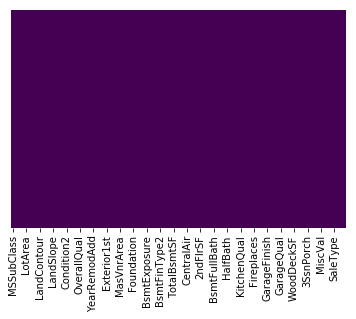

In [22]:
# rechecking if we have left any missing value
sns.heatmap(train_df.isnull(),yticklabels=False,cbar=False,cmap='viridis')

In [23]:
train_df.isnull().sum().sort_values(ascending = False).head(5)

SalePrice       0
YearRemodAdd    0
RoofMatl        0
Exterior1st     0
Exterior2nd     0
dtype: int64

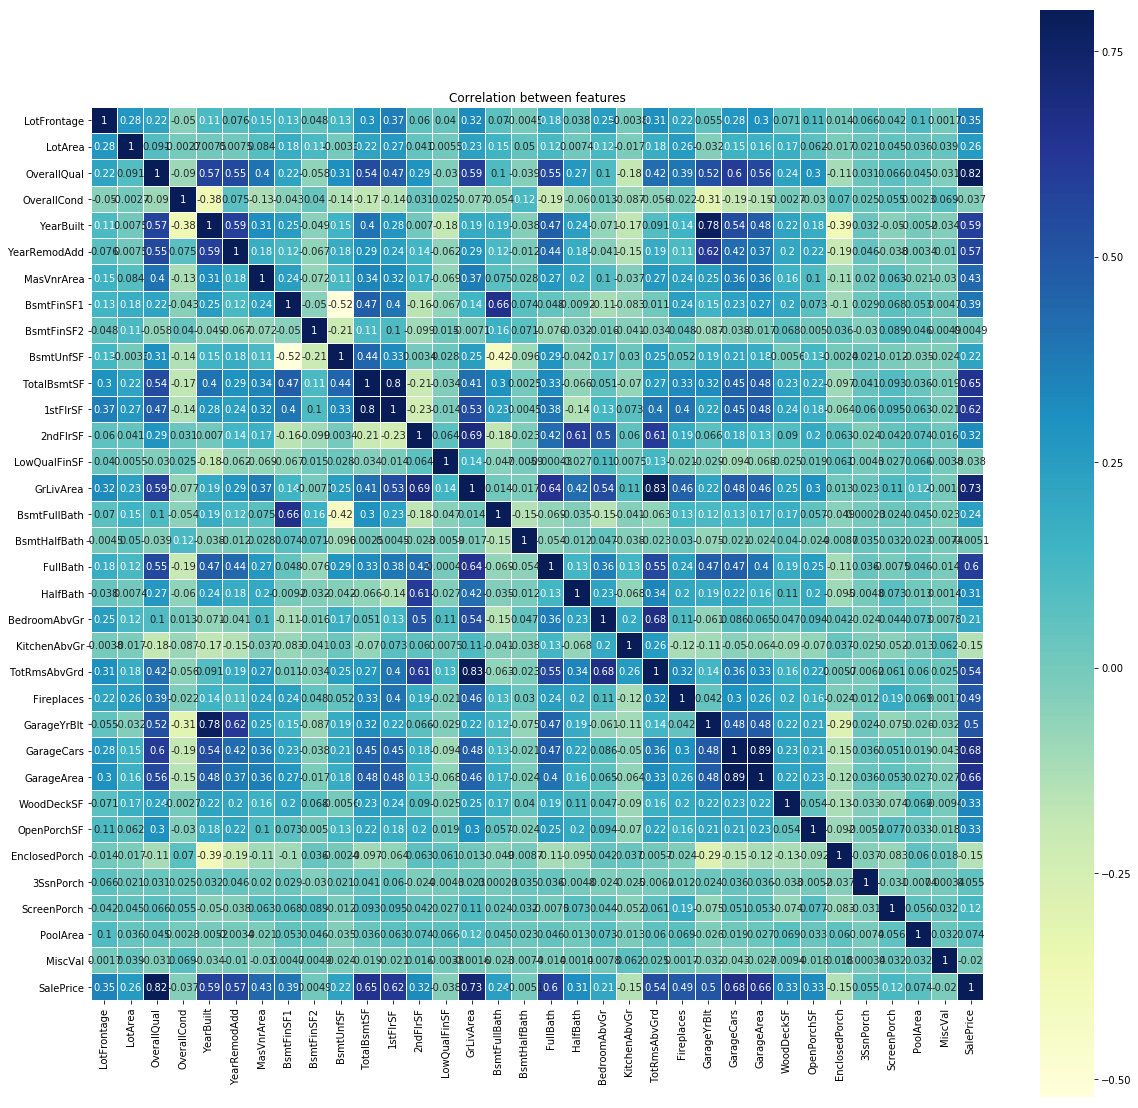

In [24]:
# checking the correlation among the features
corr=train_df.corr()
plt.figure(figsize= (20,20))
sns.heatmap(corr, vmax=.8, linewidths=0.01,
            square=True,annot=True,cmap='YlGnBu',linecolor="white")
plt.title('Correlation between features');

In [75]:
#Correlation with output variable
cor_target = abs(corr["SalePrice"])
#Selecting highly correlated features
rel_feat = cor_target.sort_values()
rel_feat

BsmtFinSF2       0.004863
BsmtHalfBath     0.005124
MiscVal          0.020012
OverallCond      0.036821
LowQualFinSF     0.037951
3SsnPorch        0.054914
PoolArea         0.074338
ScreenPorch      0.121245
KitchenAbvGr     0.147534
EnclosedPorch    0.149029
BedroomAbvGr     0.209035
BsmtUnfSF        0.221892
BsmtFullBath     0.237099
LotArea          0.260544
HalfBath         0.314186
2ndFlrSF         0.319953
OpenPorchSF      0.325215
WoodDeckSF       0.334251
LotFrontage      0.352231
BsmtFinSF1       0.392283
MasVnrArea       0.433332
Fireplaces       0.491998
GarageYrBlt      0.500972
TotRmsAbvGrd     0.537702
YearRemodAdd     0.565992
YearBuilt        0.587043
FullBath         0.595899
1stFlrSF         0.620500
TotalBsmtSF      0.647563
GarageArea       0.656129
GarageCars       0.681033
GrLivArea        0.725211
OverallQual      0.821405
SalePrice        1.000000
Name: SalePrice, dtype: float64

In [25]:
#sns.set()
#sns.pairplot(train_df, size = 2.5)
#plt.show()

In [27]:
X_train=train_df.drop(['SalePrice'],axis=1)

y_train=train_df['SalePrice']

X_train.shape

(1458, 74)

In [28]:
test_df= pd.read_csv('test_nonnorm.csv')
test_df.head(5)
test_df.shape

(1459, 74)

In [29]:
final_df = pd.concat([X_train, test_df], axis = 0)
final_df.shape

(2917, 74)

In [30]:
numeric_feats = final_df.dtypes[final_df.dtypes != "object"].index

skewed_feats = final_df[numeric_feats].apply(lambda x: skew(x)).sort_values(ascending=False)

print("\nSkewness in numerical features of dataset: \n")
skewness = pd.DataFrame({'Skewness' :skewed_feats})
skewness


Skewness in numerical features of dataset: 



,Skewness
MiscVal,21.939672
PoolArea,17.688664
LotArea,13.109495
LowQualFinSF,12.084539
3SsnPorch,11.372080
KitchenAbvGr,4.300550
BsmtFinSF2,4.144375
EnclosedPorch,4.002344
ScreenPorch,3.945101
BsmtHalfBath,3.929996


In [31]:
high_skew = skewed_feats[abs(skewed_feats) > 0.1]
skewed_features = high_skew.index
lam = 0.15
for feat in skewed_features:
    final_df[feat] = boxcox1p(final_df[feat], lam)

In [32]:
final_df.head(5)

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,...,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,60,RL,5.831328,19.212182,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,5.714669,0.000000,0.0,0.0,0.0,0.0,2,2008,WD,Normal
1,20,RL,6.221214,19.712205,Pave,Reg,Lvl,AllPub,FR2,Gtl,...,0.000000,0.000000,0.0,0.0,0.0,0.0,5,2007,WD,Normal
2,60,RL,5.914940,20.347241,Pave,IR1,Lvl,AllPub,Inside,Gtl,...,5.053371,0.000000,0.0,0.0,0.0,0.0,9,2008,WD,Normal
3,70,RL,5.684507,19.691553,Pave,IR1,Lvl,AllPub,Corner,Gtl,...,4.745132,8.797736,0.0,0.0,0.0,0.0,2,2006,WD,Abnorml
4,60,RL,6.314735,21.325160,Pave,IR1,Lvl,AllPub,FR2,Gtl,...,6.314735,0.000000,0.0,0.0,0.0,0.0,12,2008,WD,Normal


In [33]:
final_df.shape

(2917, 74)

In [30]:
# Here we are loading our cleaned test dataset.
# the reason we are loading test dataset is beacause after analysis we have figured out that the number of categories in some of
# the features are different in train and test data set.


(1459, 74)

In [31]:
# There are 75 columns in train dataset, because there is target feature 'Saleprice' is present here.
#train_df.head(5)

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,...,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,60,RL,5.831328,19.212182,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,0.000000,0.0,0.0,0.0,0.0,2,2008,WD,Normal,12.247699
1,20,RL,6.221214,19.712205,Pave,Reg,Lvl,AllPub,FR2,Gtl,...,0.000000,0.0,0.0,0.0,0.0,5,2007,WD,Normal,12.109016
2,60,RL,5.914940,20.347241,Pave,IR1,Lvl,AllPub,Inside,Gtl,...,0.000000,0.0,0.0,0.0,0.0,9,2008,WD,Normal,12.317171
3,70,RL,5.684507,19.691553,Pave,IR1,Lvl,AllPub,Corner,Gtl,...,8.797736,0.0,0.0,0.0,0.0,2,2006,WD,Abnorml,11.849405
4,60,RL,6.314735,21.325160,Pave,IR1,Lvl,AllPub,FR2,Gtl,...,0.000000,0.0,0.0,0.0,0.0,12,2008,WD,Normal,12.429220


In [32]:
# Making a final dataset for feature engineering by joing test and train datasets.


(2917, 75)

In [35]:
# Making a list of only categorical features for OneHotEncoding
df_object = final_df.dtypes == object
categorical_col = final_df.columns[df_object].tolist()
categorical_col

['MSSubClass',
 'MSZoning',
 'Street',
 'LotShape',
 'LandContour',
 'Utilities',
 'LotConfig',
 'LandSlope',
 'Neighborhood',
 'Condition1',
 'Condition2',
 'BldgType',
 'HouseStyle',
 'RoofStyle',
 'RoofMatl',
 'Exterior1st',
 'Exterior2nd',
 'MasVnrType',
 'ExterQual',
 'ExterCond',
 'Foundation',
 'BsmtQual',
 'BsmtCond',
 'BsmtExposure',
 'BsmtFinType1',
 'BsmtFinType2',
 'Heating',
 'HeatingQC',
 'CentralAir',
 'Electrical',
 'KitchenQual',
 'Functional',
 'GarageType',
 'GarageFinish',
 'GarageQual',
 'GarageCond',
 'PavedDrive',
 'MoSold',
 'YrSold',
 'SaleType',
 'SaleCondition']

In [36]:
new_df = final_df[['MSZoning', 'Street','LotShape','LandContour','Utilities','LotConfig','LandSlope','Neighborhood', 'Condition2','BldgType','Condition1','HouseStyle','SaleType', 'SaleCondition','ExterCond', 'ExterQual','Foundation','BsmtQual','BsmtCond','BsmtExposure','BsmtFinType1','BsmtFinType2', 'RoofStyle','RoofMatl','Exterior1st','Exterior2nd','MasVnrType','Heating','HeatingQC', 'CentralAir', 'Electrical','KitchenQual','Functional', 'GarageType','GarageFinish','GarageQual','GarageCond','PavedDrive']]
new_df.head(5)

,MSZoning,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition2,BldgType,...,HeatingQC,CentralAir,Electrical,KitchenQual,Functional,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive
0,RL,Pave,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,1Fam,...,Ex,Y,SBrkr,Gd,Typ,Attchd,RFn,TA,TA,Y
1,RL,Pave,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Norm,1Fam,...,Ex,Y,SBrkr,TA,Typ,Attchd,RFn,TA,TA,Y
2,RL,Pave,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,1Fam,...,Ex,Y,SBrkr,Gd,Typ,Attchd,RFn,TA,TA,Y
3,RL,Pave,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,1Fam,...,Gd,Y,SBrkr,Gd,Typ,Detchd,Unf,TA,TA,Y
4,RL,Pave,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,1Fam,...,Ex,Y,SBrkr,Gd,Typ,Attchd,RFn,TA,TA,Y


In [37]:
# perofrming OneHotEncoding on categorical features of the dataset.
# To avoid the dummy variable trap, we are dropping the first dummy variable columns.
temp_df = pd.concat([pd.get_dummies(new_df[col], drop_first = True) for col in new_df], axis=1)
temp_df.shape

(2917, 206)

In [38]:
# dropping the original columns for which we have created dummy variables
for col in categorical_col:
    final_df.drop([col], axis = 1, inplace= True)

In [39]:
final_df.shape

(2917, 33)

In [40]:
# finally concatinating our dummy variable with our original dataset
onehot_df = pd.concat([final_df, temp_df], axis = 1)
onehot_df.shape

(2917, 239)

In [41]:
onehot_df.head(5)

,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,...,Gd,Po,TA,Ex,Fa,Gd,Po,TA,P,Y
0,5.831328,19.212182,2.440268,2.055642,14.187527,14.187527,8.059126,11.170327,0.0,7.483296,...,0,0,1,0,0,0,0,1,0,1
1,6.221214,19.712205,2.259674,2.602594,14.145138,14.145138,0.000000,12.062832,0.0,8.897844,...,0,0,1,0,0,0,0,1,0,1
2,5.914940,20.347241,2.440268,2.055642,14.184404,14.185966,7.646538,10.200343,0.0,9.917060,...,0,0,1,0,0,0,0,1,0,1
3,5.684507,19.691553,2.440268,2.055642,14.047529,14.135652,0.000000,8.274266,0.0,10.468500,...,0,0,1,0,0,0,0,1,0,1
4,6.314735,21.325160,2.602594,2.055642,14.182841,14.182841,9.391827,10.971129,0.0,10.221051,...,0,0,1,0,0,0,0,1,0,1


In [42]:
# Dropping all the duplicate columns
onehot_df =onehot_df.loc[:,~onehot_df.columns.duplicated()]
onehot_df.shape

(2917, 179)

In [43]:
# since we have created dummy variable for every category of every feau=ture, lets seperate back our train and test dataset.
X_train = onehot_df.iloc[:1458, :]
test_set = onehot_df.iloc[1458:, :]

In [44]:
#test_set = test_set.drop(['SalePrice'], axis =1)
test_set.shape

(1459, 179)

In [45]:
X_train.shape

(1458, 179)

In [44]:
# Seperating out target and predictor variables for model training
#X_train=train_set.drop(['SalePrice'],axis=1)
#y_train=train_set['SalePrice']

In [46]:
# Model Creation
# Random Forest Regression will be the first model to predict hous sale price.

RF_model = RandomForestRegressor()
RF_model.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=10,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

In [47]:
# Since we are going to perform the hyperparameter tuning for this model.
# Hence creating a matix of parameters to train our model.

bootstrap=  [True, False]
max_depth= [2, 3, 5, 10, None]
max_features = ['auto', 'sqrt']
min_samples_leaf= [1, 2, 4]
min_samples_split= [2, 5, 10]
n_estimators= [50, 100, 200, 300, 500, 700]


In [48]:
forest_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

In [49]:
# Using the RandomizedSearchCV for hyper-parameter tuning
RF_rdcv = RandomizedSearchCV(estimator=RF_model,
            param_distributions=forest_grid,
            cv=5, n_iter=10,
            scoring = 'neg_mean_absolute_error', verbose = 3, n_jobs = -1,
            return_train_score = True,
            random_state=42)

In [50]:
RF_rdcv.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] n_estimators=200, min_samples_split=10, min_samples_leaf=4, max_features=sqrt, max_depth=5, bootstrap=False 


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  n_estimators=200, min_samples_split=10, min_samples_leaf=4, max_features=sqrt, max_depth=5, bootstrap=False, score=(train=-0.108, test=-0.111), total=   0.5s
[CV] n_estimators=200, min_samples_split=10, min_samples_leaf=4, max_features=sqrt, max_depth=5, bootstrap=False 


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.6s remaining:    0.0s


[CV]  n_estimators=200, min_samples_split=10, min_samples_leaf=4, max_features=sqrt, max_depth=5, bootstrap=False, score=(train=-0.107, test=-0.128), total=   0.5s
[CV] n_estimators=200, min_samples_split=10, min_samples_leaf=4, max_features=sqrt, max_depth=5, bootstrap=False 


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    1.1s remaining:    0.0s


[CV]  n_estimators=200, min_samples_split=10, min_samples_leaf=4, max_features=sqrt, max_depth=5, bootstrap=False, score=(train=-0.107, test=-0.120), total=   0.4s
[CV] n_estimators=200, min_samples_split=10, min_samples_leaf=4, max_features=sqrt, max_depth=5, bootstrap=False 
[CV]  n_estimators=200, min_samples_split=10, min_samples_leaf=4, max_features=sqrt, max_depth=5, bootstrap=False, score=(train=-0.108, test=-0.116), total=   0.5s
[CV] n_estimators=200, min_samples_split=10, min_samples_leaf=4, max_features=sqrt, max_depth=5, bootstrap=False 
[CV]  n_estimators=200, min_samples_split=10, min_samples_leaf=4, max_features=sqrt, max_depth=5, bootstrap=False, score=(train=-0.107, test=-0.120), total=   0.5s
[CV] n_estimators=50, min_samples_split=2, min_samples_leaf=2, max_features=sqrt, max_depth=None, bootstrap=False 
[CV]  n_estimators=50, min_samples_split=2, min_samples_leaf=2, max_features=sqrt, max_depth=None, bootstrap=False, score=(train=-0.031, test=-0.088), total=   0.3s


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  1.6min finished


RandomizedSearchCV(cv=5, error_score='raise-deprecating',
                   estimator=RandomForestRegressor(bootstrap=True,
                                                   criterion='mse',
                                                   max_depth=None,
                                                   max_features='auto',
                                                   max_leaf_nodes=None,
                                                   min_impurity_decrease=0.0,
                                                   min_impurity_split=None,
                                                   min_samples_leaf=1,
                                                   min_samples_split=2,
                                                   min_weight_fraction_leaf=0.0,
                                                   n_estimators=10, n_jobs=None,
                                                   oob_score=False,
                                                   random_state=N...


In [51]:
# With the help of best estimator we can have a set of parametes which give the best score.
RF_rdcv.best_estimator_

RandomForestRegressor(bootstrap=False, criterion='mse', max_depth=None,
                      max_features='sqrt', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=2, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=50,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

In [52]:
# Retraining our model on the best parameters possible
RF_model = RandomForestRegressor(bootstrap=False, criterion='mse', max_depth=None,
                      max_features='sqrt', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=2, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=50,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)
RF_model.fit(X_train, y_train)

RandomForestRegressor(bootstrap=False, criterion='mse', max_depth=None,
                      max_features='sqrt', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=2, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=50,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

In [53]:
# Predicting the sale price of houses in the test dataset.
RF_pred = RF_model.predict(test_set)
RF_df = pd.DataFrame(RF_pred, columns = ['RF_pred'])
RF_df.head()

,RF_pred
0,11.730327
1,11.935835
2,12.156451
3,12.167836
4,12.149224


In [54]:
RF_pred_nat = np.floor(np.expm1(RF_model.predict(test_set)))
RF_pred_nat = pd.DataFrame(RF_pred_nat, columns = ['RF_pred'])
RF_pred_nat.head()

,RF_pred
0,124283.0
1,152638.0
2,190316.0
3,192495.0
4,188946.0


In [55]:
# cheacking the score of out model performance
RF_model.score(X_train, y_train)

0.9854554242118589

In [56]:
# XGBoost regression will be our second model to predict the sale prices of the houses

XGB_model=xgboost.XGBRegressor(objective ='reg:squarederror')
XGB_model.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
             n_jobs=1, nthread=None, objective='reg:squarederror',
             random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             seed=None, silent=None, subsample=1, verbosity=1)

In [57]:
# Creating a matix of parameters for the hyper parameter tunning of this model
n_estimators = [50, 100, 200, 300, 500]
max_depth = [2, 3, 5, 10]
booster=['gbtree','gblinear']
learning_rate=[0.05,0.1,0.15,0.20]
min_child_weight=[1,2,3,4]
base_score=[0.25,0.5,0.75,1]

In [58]:
XGB_hyperparameter_grid = {
    'n_estimators': n_estimators,
    'max_depth':max_depth,
    'learning_rate':learning_rate,
    'min_child_weight':min_child_weight,
    'booster':booster,
    'base_score':base_score
    }

In [59]:
# Using the RandomizedSearchCV for hyperparameter tuning
XGB_rdcv = RandomizedSearchCV(estimator=XGB_model,
            param_distributions=XGB_hyperparameter_grid,
            cv=5, n_iter=10,
            scoring = 'neg_mean_absolute_error', verbose = 3, n_jobs = -1,
            return_train_score = True,
            random_state=42)

In [60]:

XGB_rdcv.fit(X_train,y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] n_estimators=50, min_child_weight=1, max_depth=10, learning_rate=0.15, booster=gbtree, base_score=0.5 


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  n_estimators=50, min_child_weight=1, max_depth=10, learning_rate=0.15, booster=gbtree, base_score=0.5, score=(train=-0.022, test=-0.094), total=   0.8s
[CV] n_estimators=50, min_child_weight=1, max_depth=10, learning_rate=0.15, booster=gbtree, base_score=0.5 


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.8s remaining:    0.0s


[CV]  n_estimators=50, min_child_weight=1, max_depth=10, learning_rate=0.15, booster=gbtree, base_score=0.5, score=(train=-0.022, test=-0.094), total=   0.7s
[CV] n_estimators=50, min_child_weight=1, max_depth=10, learning_rate=0.15, booster=gbtree, base_score=0.5 


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    1.5s remaining:    0.0s


[CV]  n_estimators=50, min_child_weight=1, max_depth=10, learning_rate=0.15, booster=gbtree, base_score=0.5, score=(train=-0.022, test=-0.093), total=   0.7s
[CV] n_estimators=50, min_child_weight=1, max_depth=10, learning_rate=0.15, booster=gbtree, base_score=0.5 
[CV]  n_estimators=50, min_child_weight=1, max_depth=10, learning_rate=0.15, booster=gbtree, base_score=0.5, score=(train=-0.022, test=-0.086), total=   0.7s
[CV] n_estimators=50, min_child_weight=1, max_depth=10, learning_rate=0.15, booster=gbtree, base_score=0.5 
[CV]  n_estimators=50, min_child_weight=1, max_depth=10, learning_rate=0.15, booster=gbtree, base_score=0.5, score=(train=-0.021, test=-0.093), total=   0.7s
[CV] n_estimators=500, min_child_weight=3, max_depth=2, learning_rate=0.05, booster=gbtree, base_score=0.75 
[CV]  n_estimators=500, min_child_weight=3, max_depth=2, learning_rate=0.05, booster=gbtree, base_score=0.75, score=(train=-0.061, test=-0.084), total=   1.8s
[CV] n_estimators=500, min_child_weight=3,

[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   48.5s finished


RandomizedSearchCV(cv=5, error_score='raise-deprecating',
                   estimator=XGBRegressor(base_score=0.5, booster='gbtree',
                                          colsample_bylevel=1,
                                          colsample_bynode=1,
                                          colsample_bytree=1, gamma=0,
                                          importance_type='gain',
                                          learning_rate=0.1, max_delta_step=0,
                                          max_depth=3, min_child_weight=1,
                                          missing=None, n_estimators=100,
                                          n_jobs=1, nthread=None,
                                          objective='reg:squarederror',
                                          ran...
                   iid='warn', n_iter=10, n_jobs=-1,
                   param_distributions={'base_score': [0.25, 0.5, 0.75, 1],
                                        'booster': ['gbtree'

In [61]:
XGB_rdcv.best_estimator_

XGBRegressor(base_score=1, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.2, max_delta_step=0,
             max_depth=2, min_child_weight=2, missing=None, n_estimators=500,
             n_jobs=1, nthread=None, objective='reg:squarederror',
             random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             seed=None, silent=None, subsample=1, verbosity=1)

In [62]:
XGB_model=xgboost.XGBRegressor(base_score=1, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.2, max_delta_step=0,
             max_depth=2, min_child_weight=2, missing=None, n_estimators=500,
             n_jobs=1, nthread=None, objective='reg:squarederror',
             random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             seed=None, silent=None, subsample=1, verbosity=1)

In [63]:
# Retraining our model on the best parameters possible
XGB_model.fit(X_train, y_train)

XGBRegressor(base_score=1, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.2, max_delta_step=0,
             max_depth=2, min_child_weight=2, missing=None, n_estimators=500,
             n_jobs=1, nthread=None, objective='reg:squarederror',
             random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             seed=None, silent=None, subsample=1, verbosity=1)

In [64]:
# Predicting the sale price of houses in the test dataset with XGBoost.
XGB_pred = XGB_model.predict(test_set)
XGB_pred = np.floor(np.expm1(XGB_pred))
XGB_df = pd.DataFrame(XGB_pred, columns = ['SalePrice'])
XGB_df


,SalePrice
0,120412.0
1,156598.0
2,190307.0
3,199151.0
4,179279.0
5,173967.0
6,169243.0
7,170438.0
8,181973.0
9,125406.0


In [65]:
# Checking our model performance score
XGB_model.score(X_train, y_train)

0.9781183694373017

In [66]:
# Just out of curiosity, checking how close is our prediction with the given sale price in train set.
#train_pred = XGB_model.predict(X_train)

train_pred = np.expm1(XGB_model.predict(X_train))

train_pred = pd.DataFrame(train_pred)
pred_compr = pd.concat([train_pred, y_train ], axis =1)
pred_compr.columns = ['pred_saleprice', 'given_saleprice']
pred_compr.head()

,pred_saleprice,given_saleprice
0,205494.625000,12.247699
1,180731.359375,12.109016
2,212867.062500,12.317171
3,150301.812500,11.849405
4,298851.406250,12.429220


In [67]:
# for the sake of submission on kaggle , creating a seperate submission file for Kaggle competition.
test_data= pd.read_csv('test.csv')

In [68]:
test_id = test_data.iloc[:, :1]
test_id.shape

(1459, 1)

In [69]:
XGB_df

,SalePrice
0,120412.0
1,156598.0
2,190307.0
3,199151.0
4,179279.0
5,173967.0
6,169243.0
7,170438.0
8,181973.0
9,125406.0


In [71]:
XGB_df
output_file = pd.concat([test_id, XGB_df], axis =1)

In [72]:
output_file.to_csv('trntst_submission_file.csv', index = False)